# Homework 1 - data validation & cleaning (deadline 31. 10. 2020)

In short, the main task is to clean The Metropolitan Museum of Art Open Access dataset.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

## What are you supposed to do:

  1. Download the dataset MetObjects.csv from the repository https://github.com/metmuseum/openaccess/.
  2. Check consistency (i.e. that same things are represented in the same way) of at least three features where you expect problems (include "Object Name" feature). You can propose how to clean selected features, however do not apply cleaning (in your interest) :)
  3. Select some features where you expect integrity problems (describe your choice) and check integrity of those features. By integrity we mean correct logical relations between features (e.g. female names for females only).
  4. Convert at least five features to a proper data type. Choose at least one numeric, one categorical and one datetime.
  5. Find some outliers (describe your method).
  6. Detect missing data in at least three features, convert them to a proper representation (if they are already not), and impute missing values in at least one feature.

**If you do all this properly, you will obtain 16 points.** However, all your steps and following code **have to be commented!**

To earn **two points** for extra activity you can do some of these:
  * Focus more precisely on cleaning of the "Medium" feature. Such if you like to use it in KNN based algorithms later.
  * Focus on the extraction of physical dimensions of each item (width, depth and height in centimeters) from the "Dimensions" feature.

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)

## Insert
   * Nejprve naimportujeme všechny potřebné knihovny

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None
import math
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('MetObjects.csv', low_memory=False)
df.head(5)

,Object Number,Is Highlight,Is Timeline Work,Is Public Domain,Object ID,Gallery Number,Department,AccessionYear,Object Name,Title,...,River,Classification,Rights and Reproduction,Link Resource,Object Wikidata URL,Metadata Date,Repository,Tags,Tags AAT URL,Tags Wikidata URL
0,1979.486.1,False,False,False,1,NaN,The American Wing,1979,Coin,One-dollar Liberty Head Coin,...,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/1,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
1,1980.264.5,False,False,False,2,NaN,The American Wing,1980,Coin,Ten-dollar Liberty Head Coin,...,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/2,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
2,67.265.9,False,False,False,3,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/3,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
3,67.265.10,False,False,False,4,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/4,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN
4,67.265.11,False,False,False,5,NaN,The American Wing,1967,Coin,Two-and-a-Half Dollar Coin,...,NaN,Metal,NaN,http://www.metmuseum.org/art/collection/search/5,NaN,NaN,"Metropolitan Museum of Art, New York, NY",NaN,NaN,NaN


In [3]:
#V případě potřeby je možné vypsat základní informace o všech příznacích
#display(df.info())

## 2. Kontrola konzistence - příznak "Object Name"

 * Jelikož se jedná o název nějakého objektu, měly by mít názvy nějakou rozumnou délku. Proto byl nejprve přidán příznak "ObjectNameLen", který obsahuje délku názvu objektu. První výstup nám zobrazí nejkratší a nejdelší názvy. Můžeme si všimnout obrovských rozdílů, máme zde názvy, které obsahují pouze dva znaky,což s největší pravděpodobností nebudou platné názvy. Naopak delší názvy mají klidně 13 slov, to ale nemůžeme považovat za chybu. V případě, že bychom chtěli příznak použít pro nějaké výpočty, je lepší možnost předpokládat, že názvy s kratší délkou než 3 nejsou validní (pro délku 3 lze najít slova, co dávají smysl).
 * První výstup také ukazuje, že některé hodnoty nejsou definované (NaN). V připadě, že bychom chtěli příznak použít pro nějaké výpočty, bylo by lepší tyto hodnoty smazat. 
 * Další výstup vrací počet hodnot, které již v souboru existují, akorát se liší ve velkých/malých písmenech. V dalším výstupu jsou vypsány názvy, které nejsou tímto způsobem unikátní nebo názvy, které nemají na začátku velké písmeno, což je gramaticky trochu zvláštní. Můžeme si všimnout, že některý název je zapsán 4 různými způsoby ('Print' 'print' 'pRINT' 'PRINT'). Jediná možnost, jak takový nedostatek opravit, je převést vše do Lowercase nebo Uppercase.
 * Dále se dá předpokládat, že nekonzistentní názvy budou možná obsahovat nějaký speciální symbol. Správné by bylo vyzkoušet všechny, v tomto řešení se omezíme pouze na '?, '!', '/', '+' a '\n'. Můžeme si všimnout, že každý z těchto symbolů může vrátit nějaký pochybný název. Otazník v závorce může naznačit, že název nemusí být zcela správný, hláška "check date and identification !!" také do názvu asi nepatří, hledání lomítka zase našlo názvy připomínající HTML jazyk, symbol pro novou řádku nemusí nutně představovat chybu, ale na první pohled také nebudí zrovna dobrý dojem. HTML prvky, \n a \r symboly by možná bylo lepší odstranit, názvy s "(?)" raději nepovažovat za validní.
 * Dále, jak už bylo řečeno, je zde mnoho hodnot NaN. 
 * Poslední věc, která byla nalezena náhodou, lze vidět v jednom z předchozích bodů (bod 3 - malá/velká písmena). Některé názvy obsahují id jiného objektu (např. "see 57.180.42" nebo "joined with 26.7.1236"). Jednou z možností, jak tuto skutečnost opravit, je přidání nového příznaku, který by obsahoval informaci o případné vazbě na jiný objekt.

In [4]:
df['ObjectNameLen'] = df['Object Name'].str.len()

In [5]:
print("Ukázka hodnot:\n")
print(df.sort_values(by='ObjectNameLen', ascending=True)['Object Name'].unique())

Ukázka hodnot:

['Ax' 'Ūd' 'Se' ...
 'Top two lames from a right thigh defense (Cuisse), possibly from armor for a boy'
 'Mummy Label, Petemin, son of Petempto, son of Petemin the Younger, mother Thatre'
 nan]


In [6]:
print("Počet neunikátních hodnot: " + str(df['Object Name'].unique().size - df['Object Name'].str.lower().unique().size))

Počet neunikátních hodnot: 823


In [7]:
df10 = df['Object Name'].unique()
df11 = df['Object Name'].str.lower().unique()

In [8]:
print("Ukázka stejných hodnot zapsaných různým způsobem:\n")
for x in df10:
    if x in df11:
        iArray = df[df['Object Name'].str.lower()==x]['Object Name'].unique()
        if iArray.size > 1:
            print(iArray)

Ukázka stejných hodnot zapsaných různým způsobem:

['Woodblock print (nishiki-e)' 'woodblock print (nishiki-e)']
['Panel' 'panel']
['Illustrated books' 'illustrated books']
['Illustrated book' 'Illustrated Book' 'illustrated book']
['Whorl' 'whorl']
['Pilaster fragment' 'pilaster fragment']
['Seal, amygdaloid' 'seal, amygdaloid']
['Seal, lentoid' 'seal, lentoid']
['Mold fragment' 'mold fragment']
['Intaglio' 'intaglio']
['Bell-krater' 'bell-krater']
['Carte-de-visite' 'Carte-de-Visite' 'carte-de-visite']
['Print ornament & architecture' 'Print Ornament & Architecture'
 'print ornament & architecture' 'Print Ornament & architecture']
['Print' 'print' 'pRINT' 'PRINT']
['Lamp' 'lamp']
['Ring' 'ring']
['Jar' 'jar']
['Fragment' 'fragment']
['Hairpin' 'hairpin']
['Sculpture' 'sculpture']
['Statue' 'statue']
['Statuette' 'statuette']
['Teapot' 'teapot']
['Harp' 'harp']
['tube zither' 'Tube zither' 'Tube Zither']
['Tabl-i baz' 'tabl-i baz']
['circular trumpet' 'Circular Trumpet']
['ax handle' 

In [9]:
print("Ukázka hodnot obsahující otazník:\n")
print(df[df['Object Name'].str.contains('?', regex=False)==True]['Object Name'].unique()[:10])

Ukázka hodnot obsahující otazník:

['Lamp shade (?)' 'Earring(?)' 'Dish(?)' 'Dance wand hilt (?)'
 'Fitting for a chariot (?)' 'Baton handle or penis sheath (?)'
 'Reliquary (?)' 'Lid fragment (?)' 'Standing male ruler (?)'
 'Ink well (?)']


In [10]:
print("Hodnoty obsahující vykřičník:\n")
print(df[df['Object Name'].str.contains('!', regex=False)==True]['Object Name'].unique())

Hodnoty obsahující vykřičník:

['Head amulet, ram or Hathor ? check date and identification !!']


In [11]:
print("Ukázka hodnot obsahující lomítko:\n")
print(df[df['Object Name'].str.contains('/', regex=False)==True]['Object Name'].unique()[:10])

Ukázka hodnot obsahující lomítko:

['Blade and mounting for a short sword (<i>Wakizashi</i>)'
 'Combined wheellock/matchlock gun' 'Armor (<i>Gusoku</i>)'
 'Blade for a double-edged sword (<i>Ken</i>)' 'Stirrup (<i>Wa abumi</i>)'
 'Ceremonial spearhead (<i>Tsukushi boko</i>)' 'Surcoat (<i>Jinbaori</i>)'
 'Priming flask/spanner' 'Pair of greaves (<i>Suné-até</i>)'
 'Cuirass of a <i>Tankō</i>']


In [12]:
print("Hodnoty obsahující plus:\n")
print(df[df['Object Name'].str.contains('+', regex=False)==True]['Object Name'].unique())

Hodnoty obsahující plus:

['Jar Label,wine, irp, year 31 + 3, year 34']


In [13]:
print("Hodnoty obsahující \\n:\n")
print(df[df['Object Name'].str.contains('\n', regex=False)==True]['Object Name'].unique()[:10])

Hodnoty obsahující \n:

['Exterior Doorway from One West Broad Street,\r\nSavannah, Georgia'
 'Fire Tongs\r\n' 'Plate\r\n'
 'Painting\r\nFrigate Presiden\r\nFrigate President and\r\nH.B.M. Endymion'
 'Panel\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\nWindow'
 'Blade and mounting for a short sword (Wakizashi) \r\n'
 'Blade and mounting for a Short Sword Wakizashi\r\n'
 'Jousting armor (<i>Rennzeug</i>) \r\nand matching half-shaffron'
 'Jousting armor (Rennzeug) \r\nand matching half-shaffron'
 'Blade and mounting for a spear (Kikuchi-yari) \r\n']


In [14]:
print ("Nedefinované hodnoty:\n")
print(df[df['Object Name'].isnull()==True]['Object Name'].unique())

Nedefinované hodnoty:

[nan]


## 2. Kontrola konzistence - příznak "AccessionYear"
 * Tento příznak byl zvolen z toho důvodu, že mnoho lidí zapisuje roky různými způsoby.
 * Při počátečním vypsání prvních řádků se zdá, že příznak by měl být ve formátu "YYYY".
 * Tuto skutečnost snadno ověříme vypsáním všech unikátních délek tohoto příznaku.
 * V prvním výstupu si můžeme všimnout délky 4, což je v pořádku, ale také délky 10 a hodnoty NaN. 
 * V dalším výstupu si můžeme všimnout, že příznak obsahuje dvě nekonzistentní hodnoty (ve formátu "YYYY-MM-DD" a také NaN hodnoty. Tuto skutečnost bychom mohli snadno opravit. Dvě zmíněné nekonzistentní hodnoty bychom mohli převést do formátu "YYYY" a NaN hodnoty nahradit například mediánem (záleží k čemu bychom příznak využívali).  

In [15]:
print("Délky hodnot příznaku:\n")
print(df['AccessionYear'].str.len().unique())

Délky hodnot příznaku:

[ 4. nan 10.]


In [16]:
print("Příznaky v jiném formátu než YYYY:\n")
print(df[df['AccessionYear'].str.len() != 4]['AccessionYear'].unique())

Příznaky v jiném formátu než YYYY:

[nan '2005-02-15' '2020-03-23']


## 2. Kontrola konzistence - příznak "Artist Nationality"
 * U příznaků začínající slovem Artist si můžeme všimnout, že velmi často se týkají hned několika umělců najednou a obsahují dané informace pro všechny tyto umělce.
 * Nejprve tedy zkontrolujeme hodnoty, které obsahují informaci pouze pro jednoho umělce. Totéž by pak bylo vhodné udělat pro hodnoty, které se týkají více umělců, postup by však byl stejný (pouze by bylo potřeba navíc rozdělit hodnoty na jednotlivé části), proto tato opakující se fáze nebude provedena.
 * V prvním výstupu je vypsána nejdelší a nejkratší hodnota příznaku. Už z toho je patrná jistá nekonzistence, jelikož nejdelší hodnota neobsahuje pouze národnost, ale také nějaké doplňující informace.
 * Na základě předchozího výstupu se dá předpokládat, že množina bude obsahovat klasické jednoslovné hodnoty ale pak také víceslovné hodnoty, které by mohly mít trochu neočekávanější tvar, tak jako v prvním výstupu.
 * Jednoslovné hodnoty byly nejprve rozděleny na dvě skupiny podle toho, zda obsahují speciální znaky. U hodnot bez speciálních znaků si můžeme všimnout, že jedna národnost je mnohdy zapsána více způsoby (např. 'France', 'French', 'french' 'Paris',). Díky seřazení dokonce vidíme hodnotu, která je zadána s malým písmenem ('French', 'french'). Malá písmena na začátku by asi nebylo těžké opravit, avšak sjednotit různé interpretace jedné národnosti do jedné, by mohlo být dost komplikované.
 * U jednoslovných hodnot se speciálními znaky si můžeme všimnout některých znaků navíc 'American,', 'American?', 'French(?)'. Některé by šlo odstranit naříklad čárky, nicméně otazník může znamenat hodnotu, která není validní. Tuto informaci by bylo dobré zpracovat.
 * U víceslovných hodnot si můžeme všimnout klidně 19 různých zápisů pro jednu národnost. Někde je totiž přidána informace o místu narození, aktivním působení, městu nebo třeba době působení. U některých je uvedeno '[search purposes only]' u jiných je zase otazník. Bylo by vhodné vytvořit nový příznak a přidanou informaci od národnosti oddělit a uložit do tohoto nového příznaku.
 * Stejný postup je pak potřeba aplikovat na hodnoty příznaků, které obsahují informace o více umělcích. Stojí za zmínku, že tento způsob ukládání, kdy do jednoho příznaku uložíme N různých hodnot, není moc vhodný. Bylo by lepší rozdělit příznaky na atomické hodnoty. To ale není součástí tohoto úkolu.

In [17]:
subSet = df[df['Artist Nationality'].str.contains('|', regex=False)==False]['Artist Nationality'].unique()
print ("Nejkratší hodnota: " + reduce(lambda x, y: x if len(x) < len(y) else y, subSet))
print ("Nejdelší hodnota: " + reduce(lambda x, y: x if len(x) > len(y) else y, subSet))

Nejkratší hodnota: Iran
Nejdelší hodnota: German-born sculptor later active in Switzerland


In [18]:
print ("Počet jednoslovných hodnot: " + str(reduce(lambda x, y: x + (1 if ' ' not in y else 0), subSet, 0)))
print ("Počet víceslovných hodnot: " + str(reduce(lambda x, y: x + (1 if ' ' in y else 0), subSet, 0)))
simpleSubSet = list(filter(lambda x: ' ' not in x, subSet))
complexSubSet = list(filter(lambda x: ' ' in x, subSet))

Počet jednoslovných hodnot: 158
Počet víceslovných hodnot: 262


In [19]:
print("Jednoslovné hodnoty bez speciálních znaků:")
sorted(list(filter(lambda x: x.isalpha(), simpleSubSet)))

Jednoslovné hodnoty bez speciálních znaků:


['Aachen',
 'Africa',
 'Albanian',
 'Alsatian',
 'American',
 'Argentinian',
 'Armenian',
 'Asmat',
 'Australian',
 'Austrian',
 'Belgian',
 'Belgium',
 'Bohemian',
 'Brazilian',
 'British',
 'Bulgarian',
 'Burgundian',
 'Byzantine',
 'Cameroon',
 'Cameroonian',
 'Canadian',
 'Chilean',
 'Chinese',
 'Colombian',
 'Congo',
 'Continental',
 'Croatian',
 'Cuban',
 'Czech',
 'Czechoslovakian',
 'Danish',
 'Dominican',
 'Dutch',
 'Ecuadorian',
 'Egyptian',
 'Emilian',
 'English',
 'European',
 'Fench',
 'Finish',
 'Finnish',
 'Flemish',
 'Florence',
 'France',
 'French',
 'Gabon',
 'Geman',
 'Georgian',
 'German',
 'Germany',
 'Ghanaian',
 'Greek',
 'Greenlandish',
 'Guatemalan',
 'Haida',
 'Hungarian',
 'Icelandic',
 'Indian',
 'Inuit',
 'Iran',
 'Iranian',
 'Irish',
 'Islamic',
 'Israeli',
 'Italian',
 'Italy',
 'Japan',
 'Japanese',
 'Kashmir',
 'Khitan',
 'Korean',
 'Kuwaiti',
 'Lebanese',
 'Lithuanian',
 'Lombard',
 'London',
 'Malaysian',
 'Malian',
 'Maltese',
 'Manchu',
 'Manufactur

In [20]:
print("Jednoslovné hodnoty se speciálními znaky:")
sorted(list(filter(lambda x: not x.isalpha(), simpleSubSet)))

Jednoslovné hodnoty se speciálními znaky:


['American,',
 'American?',
 'Argentinian?',
 'Armenian-Iranian',
 'Austrian/German',
 'Austrian?',
 'Austro-Hungarian',
 'Belgian?',
 'British/Irish',
 'British?',
 'Continental/Swiss',
 'Danish-Icelandic',
 'Dutch?',
 'Egyptian?',
 'Flemish?',
 'Franco-American',
 'Franco-Flemish',
 'Franco-Netherlandish',
 'French(?)',
 'French/Flemish',
 'French?',
 'German/Solingen',
 'German?',
 'Iranian-American',
 'Italian?',
 'Mexican?',
 'Netherlandish/French',
 'Netherlandish?',
 'Nigeria/Cameroon',
 'Polish?',
 'Serbo-croat',
 'Spanish?',
 'Swiss?']

In [21]:
print("Víceslovné hodnoty:")
sorted(complexSubSet)

Víceslovné hodnoty:


['Algonquin family',
 'American ',
 'American (born Dominican Republic)',
 'American (born Iran)',
 'American (born Russia)',
 'American (born Turkey)',
 'American German',
 'American and British, born Mexico',
 'American and Canadian',
 'American and French',
 'American born Britain',
 'American, German',
 'American, Scottish',
 'American, born Albania',
 'American, born Alsace',
 'American, born Alsace-Lorraine',
 'American, born Argentina',
 'American, born Armenia',
 'American, born Australia',
 'American, born Austria',
 'American, born Austria-Hungary',
 'American, born Belgium',
 'American, born Britain',
 'American, born Bulgaria',
 'American, born Canada',
 'American, born China',
 'American, born Cuba',
 'American, born Czech Republic',
 'American, born Denmark',
 'American, born Dominican Republic',
 'American, born Egypt',
 'American, born England',
 'American, born Federal Republic of Germany',
 'American, born Finland',
 'American, born France',
 'American, born Germany',

## 3. Kontrola integrity
 * Při kontrole integrity dat je třeba sledovat skupiny příznaků, které mezi sebou mají nějaký vztah. Při pohledu na všechny příznaky si můžeme všimnout, že určité příznaky patří do jisté podskupiny (např. ohledně kultury, umělce, data objektu nebo regionu). Na tyto skupiny příznaků a vztahy mezi jednotlivými příznaky v těchto skupinách je třeba se zaměřit. 

### Kultura
 * Máme zde příznaky Culture, Period, Dynasty, Reign. 
 * Problém může nastat v případě, že jedna dynastie bude vládnout ve dvou různých kulturách. Stejně tak jedna vláda by neměla být ve dvou různých kulturách. U ostatních dvojic či n-tic se integritní omezení vytváří příliš složitě.
 * Zde z výstupů vidíme, že je integrita v pořádku.

In [22]:
def checkIntegritySub(column1, column2, name1, name2):
    print ("Kontrola integry " + name1 + " a " + name2 + ":")
    find = False
    table = df[[column1, column2]].dropna(axis = 0, how = 'any')
    for item in table[column2].unique():
        iArray = table[table[column2]==item][column1].unique()
        if iArray.size > 1 :
            find = True
            print ("\n" + column2 + " with value " + item  +"in: \n")
            print (iArray)
    if not find :
        print ("Integrita je v pořádku.")

In [23]:
checkIntegritySub('Culture', 'Dynasty', 'kultury', 'dynastie')
checkIntegritySub('Culture', 'Reign', 'kultury', 'vlády')

Kontrola integry kultury a dynastie:
Integrita je v pořádku.
Kontrola integry kultury a vlády:
Integrita je v pořádku.


### Umělec
 * Příznaky týkající se umělce jsou 'Artist Role', 'Artist Prefix', 'Artist Display Name', 'Artist Display Bio', 'Artist Suffix', 'Artist Alpha Sort', 'Artist Nationality', 'Artist Begin Date', 'Artist End Date', 'Artist Gender', 'Artist ULAN URL', 'Artist Wikidata URL'.
 * Jeden ze vztahů můžeme nalézt mezi 'Artist Begin Date' a 'Artist End Date', kde bychom měli zkontrolovat, zda 'Artist Begin Date' je vždy před 'Artist End Date' a ne naopak. Zde si můžeme všimnout, že integrita dat není v pořádku a několik málo hodnot příznaků 'Artist End Date' je větších než 'Artist End Date'.
 * Druhý ze vztahů je mezi 'Artist Display Name' a 'Artist Gender', kde se očekává, že mužské pohlaví nebude spojeno se ženským jménem a naopak. Můžeme si všimnout, zde máme velké množství mužských jmen spojených z ženským pohlavím. Obráceně nejsme schopni ženská jména u mužů určit, jelikož  v tabulce není v 'Artist Gender' uloženo žádné mužské pohlaví.
 * Další věc, která očividně porušuje integritu dat, i přestože není samotný příznak, je počet umělců na jednotlivých řádcích. V každém příznaku by měl být na stejném řádku stejný počet oddělovačů '|'. Hned při kontrole Artist Begin Date a Artist End Date si můžeme všimnout, že v tomto smyslu nebudou hodnoty úplně v pořádku. Je tedy otázkou, zda předchozí výsledky nejsou touto skutečností ovlivněny (s největší pravděpodobností ano).

In [24]:
beginEndTable = df[['Artist Begin Date', 'Artist End Date']].dropna(axis = 0, how = 'any')
subResultTable = beginEndTable[beginEndTable['Artist Begin Date'] > beginEndTable['Artist End Date']]
subResultTable = subResultTable[subResultTable['Artist Begin Date'].str.startswith( '-' )==False]
subResultTable[subResultTable['Artist Begin Date'].str.contains('|-', regex=False )==False]

,Artist Begin Date,Artist End Date
11174,1856,1508 |1925
16513,1880 |1848,1880
16586,1909 |1877,1909
16653,1880 |1848,1880
110234,1874,1797
112455,1582,1562
206676,1492,0094
210275,1800 |1514,1534
223854,1615,1538
310081,1561,1502


In [25]:
nameGenderTable = df[['Artist Display Name', 'Artist Gender']].dropna(axis = 0, how = 'any')

In [26]:
import urllib
import json

In [27]:
names = set([item.split()[0] for item in nameGenderTable[nameGenderTable['Artist Gender']==('Female')]['Artist Display Name'].unique()])
for name in names:
    url = "https://api.genderize.io/?name=" + urllib.parse.quote(name)
    response = urllib.request.urlopen(url)
    data = json.loads(response.read())
    if data['gender'] == "male" :
        print("Nalezeno mužské jméno " + name + "!")

Nalezeno mužské jméno Emmer!
Nalezeno mužské jméno Clyde!
Nalezeno mužské jméno Michal!
Nalezeno mužské jméno Alois!
Nalezeno mužské jméno Isidore!
Nalezeno mužské jméno Akwete!
Nalezeno mužské jméno Dove!
Nalezeno mužské jméno Avis!
Nalezeno mužské jméno Sakurai!
Nalezeno mužské jméno Altoon!
Nalezeno mužské jméno Tomma!
Nalezeno mužské jméno Salle!
Nalezeno mužské jméno Coille!
Nalezeno mužské jméno Lee!
Nalezeno mužské jméno Adrian!
Nalezeno mužské jméno René!
Nalezeno mužské jméno Kiff!
Nalezeno mužské jméno Joan!
Nalezeno mužské jméno widow!
Nalezeno mužské jméno Monir!
Nalezeno mužské jméno Kishi!
Nalezeno mužské jméno Kakulu!
Nalezeno mužské jméno Dominique!
Nalezeno mužské jméno Fontana!
Nalezeno mužské jméno Elie!
Nalezeno mužské jméno Pele!
Nalezeno mužské jméno Shigeyuki!
Nalezeno mužské jméno Sascha!
Nalezeno mužské jméno Riva!
Nalezeno mužské jméno Willie!
Nalezeno mužské jméno Chris!
Nalezeno mužské jméno Kay!
Nalezeno mužské jméno Michele!
Nalezeno mužské jméno Maio!
Nal

### Datum objektu
 * Jsou zde příznaky 'Object Date', 'Object Begin Date', 'Object End Date'.
 * Příznak Object Date neobsahuje příliš konzistentní data, tudíž ho pro kontrolu integrity není moc vhodné použít. Naopak příznaky 'Object Begin Date' a 'Object End Date' májí mezi sebou vztah, že 'Object Begin Date'  musí být menší než 'Object End Date', jinak by dohromady nedávaly smysl (podobně jako u umělce). Zde vidíme, že 188 řádků tuto vlastnost nesplňuje. 

In [28]:
objectDateTable = df[['Object Begin Date', 'Object End Date']].dropna(axis = 0, how = 'all')
objectDateTable[objectDateTable['Object Begin Date'] > objectDateTable['Object End Date']]

,Object Begin Date,Object End Date
27028,5,0
32730,-45,-55
47446,1861,9
79142,1875,1800
118850,1785,1779
...,...,...
401618,1545,0
406659,0,-1
440958,2,0
451589,1,-300


### Geografická data
 * Máme zde atributy 'Geography Type', 'City', 'State', 'County','Country','Region', 'Subregion'.
 * Vztahů mezi těmito atributy můžeme najít hned několik, avšak využít tyto vztahy ke kontrole integrity je velmi komplikované. Dá se například předpokládat, že konkrétní okres nebude pravděpodobně ve více krajích, pokud by byl, je třeba se podívat, zda se nejedná o chybu. Vidíme, že byla nalezena hodnota '|', to však není validní název okresu, proto se nejedná o chybu integrity.
 * Stejně tak 'Region' a 'Subregion' sice nějaké zdánlivé problémy zobrazí, nicméně při bližším zkoumání zjistíme, že je to způsobeno odlišnými názvy pro stejné země, tudíž o problém integrity se nejedná.

In [29]:
checkIntegritySub('County', 'State', 'kraj', 'okresu')
checkIntegritySub('Region', 'Subregion', 'země', 'kraj')

Kontrola integry kraj a okresu:

State with value |in: 

['Kansas' 'Idaho, Oregon, or Washington' 'Oklahoma' 'Gujarat'
 'Northern Honan' 'Iran' 'Rhine Valley or Meuse Valley' 'Martynovka'
 'Gaul|Niederbreisig' 'Gaul' 'Bonnefont' 'Pyrénées' 'Kathmandu Valley'
 'Andes region' 'Tibet' 'Northwest' 'Kashmir|Jammu and Kashmir'
 'Central Anatolia|Deccan' 'Arkansas']
Kontrola integry země a kraj:

Subregion with value Sheikh Abd el-Qurnain: 

['Upper Egypt, Thebes' 'Upper Egypt'
 'Upper Egypt, Thebes|Upper Egypt, Thebes']

Subregion with value Saqqarain: 

['Memphite Region' 'Originally from Memphite Region']

Subregion with value Memphis (Mit Rahina)in: 

['Memphite Region' 'Memphite region']

Subregion with value Amarna (Akhetaten)in: 

['Middle Egypt' 'Middle Egypt|Middle Egypt']

Subregion with value Valley of the Kingsin: 

['Upper Egypt, Thebes' 'Upper Egypt; Thebes']

Subregion with value Malqatain: 

['Upper Egypt, Thebes' 'Upper Egypt; Thebes']

Subregion with value Southern Asasifin:

## 4. Konverze datových typů
 * Byly převedeny příznaky 'AccessionYear' (datetime), 'Department' (category), 'Constiuent ID' (numeric), 'Gallery Number' (numeric), 'Repository' (category).
 * U příznaku 'AccessionYear' bylo potřeba nejprve nahradit nekonzistentní hodnoty (viz 2. Kontrola konzistence).
 * U příznaku 'Gallery Number' bylo 15 řádků zapsáno pomocí stringu, jednalo se o hodnoty ['Façade', 'Petrie Ct. Café', 'in Great Hall', 'on Fifth Avenue']. Zbylé hodnoty byly zapsány pomocí trojciferného celého čísla. Pro odlišení původních a nových hodnot byly nekonzistentní hodnoty nahrazeny hodnotami [1, 2, 3, 4]. 

In [30]:
df['AccessionYear'] = df['AccessionYear'].apply(lambda x: str(x).split('-')[0])
df['AccessionYear'] = pd.to_datetime(df['AccessionYear'], format='%Y').astype('datetime64[Y]')

In [31]:
department_category = pd.api.types.CategoricalDtype(categories=['The American Wing', 'European Sculpture and Decorative Arts',
       'Modern and Contemporary Art', 'Arms and Armor', 'Medieval Art',
       'Asian Art', 'Islamic Art', 'Costume Institute',
       'Arts of Africa, Oceania, and the Americas', 'Drawings and Prints',
       'Greek and Roman Art', 'Photographs', 'Ancient Near Eastern Art',
       'European Paintings', 'Robert Lehman Collection', 'The Cloisters',
       'Musical Instruments', 'Egyptian Art', 'The Libraries'], ordered=False)
df['Department'] = df['Department'].astype(department_category)

In [32]:
display(df['Department'].unique())

[The American Wing, European Sculpture and Decorative Arts, Modern and Contemporary Art, Arms and Armor, Medieval Art, ..., Robert Lehman Collection, The Cloisters, Musical Instruments, Egyptian Art, The Libraries]
Length: 19
Categories (19, object): [The American Wing, European Sculpture and Decorative Arts, Modern and Contemporary Art, Arms and Armor, ..., The Cloisters, Musical Instruments, Egyptian Art, The Libraries]

In [33]:
df['Constiuent ID'] = df['Constiuent ID'].astype(float)

In [34]:
nonNumericValues = sorted(df[df['Gallery Number'].str.isdigit()==False]['Gallery Number'].unique())
df['Gallery Number'] = df['Gallery Number'].apply(lambda x: x if (str(x).isdigit() or x!=x) else str(nonNumericValues.index(x)+1))
df['Gallery Number'] = pd.to_numeric(df['Gallery Number'])

In [35]:
repository_category = pd.api.types.CategoricalDtype(categories=['Metropolitan Museum of Art, New York, NY'], ordered=False)
df['Repository'] = df['Repository'].astype(repository_category)
display(df['Repository'].unique())

[Metropolitan Museum of Art, New York, NY]
Categories (1, object): [Metropolitan Museum of Art, New York, NY]

In [36]:
df[['AccessionYear', 'Department', 'Constiuent ID', 'Gallery Number', 'Repository']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474526 entries, 0 to 474525
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   AccessionYear   470560 non-null  datetime64[ns]
 1   Department      474526 non-null  category      
 2   Constiuent ID   272672 non-null  float64       
 3   Gallery Number  54386 non-null   float64       
 4   Repository      474526 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(2)
memory usage: 11.8 MB


## 5. Anomálie

### Jeden příznak - 'Object Begin Date'
 * Pro detekci anomálií u jednoho přízaku byl zvolen příznak 'Object Begin Date', který by měl symbolizovat rok, ze kterého objekt pochází. Hledání anomálií nám pomůže určit příliš staré objekty nebo naopak příliš mladé, které by mohly představovat chyby. 
 * K vyhledání anomálií byla zvolena technika z přednášky (rule of thumbs), která najde anomálie vně intervalu (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR), kde Q1 je 25%-kvantil, Q3 je 75%-kvantil a IQR je rozsah mezi těmito kvantily.
 * Můžeme si všimnout, že metoda nalezla v horní polovině objekty s hodnotou příznaku 5000, což je velmi zvláštní vzhledem k tomu, že se právě píše rok 2020. Tyto dva objekty budou nejspíše chybně zadanou hodnotou, jinak bychom museli uvažovat nad teoriemi, že objekt pochází z budoucnosti. V dolní polovině si zase můžeme všimnout extrémně nízkých hodnot příznaku, což ale může značit extrémní stáří daného předmětu a nemusí jít nutně o chybu.

In [37]:
col = 'Object Begin Date'
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR =  Q3 - Q1
DateOut = (df[col] > Q3[col] + 1.5*IQR[col]) | (df[col] < Q1[col] - 1.5*IQR[col])
display("Počet anomálií: " + str(DateOut.sum()))
outData = df[DateOut].sort_values([col], ascending = False)

'Počet anomálií: 89620'

In [38]:
outData[['Object ID', 'Object Name', col, 'Object End Date']].head()

,Object ID,Object Name,Object Begin Date,Object End Date
336164,502410,Bell,5000,0
335935,502176,Bell,5000,1
33383,39179,Figurine,976,1049
43417,50438,Dagger,976,1499
33257,39047,Figurine,976,1049


In [39]:
outData[['Object ID', 'Object Name', col, 'Object End Date']].tail()

,Object ID,Object Name,Object Begin Date,Object End Date
363911,573092,"Tool, point, Levallois",-240000,-40000
363909,573090,"Tool, denticulate, Levallois",-240000,-40000
470122,832566,Biface,-300050,-125000
363923,573104,"Tool, biface, hand ax, sub-cordiform",-400000,-240000
363915,573096,"Tool, Biface, Hand-axe, Ovate",-400000,-240000


### Více příznaků - Délka jména objektu a životnost objektu
 * Pro tuto část byly vytvořeny příznaky 'ObjectNameLen' (délka názvu objektu) a 'Object Duration' životnost objektu. 
 * Následně bylo pomocí algoritmu K-Means vytvořeno 8 clusterů a z centroidů těchto clusterů byly nalezeny objekty s největší vzdáleností od centroidů. 
 * 5 z nich bylo vypsáno. Můžeme si všimnout, že nalezené anomálie tvoří objekty s velmi malou délkou názvu, ale s poměrně dlouhou životností. Na 4. a 5. pozici si opět můžeme všimnout dvou anomálií z předchozího příkladu, které mají chybně zadány parametry. I touto metodou jsme tedy objevili největší anomálie.
 * V grafu si můžeme všimnout jednotlivých shluků a také separovaných bodů, které představují dané anomálie.

In [40]:
df['ObjectNameLen'] = df['Object Name'].str.len()
df['Object Duration'] = df['Object End Date'] - df['Object Begin Date']

,Object ID,ObjectNameLen,Object Duration
365660,590917,4.0,60000
470122,832566,6.0,175050
100045,188903,4.0,13812
336164,502410,4.0,-5000
335935,502176,4.0,-4999


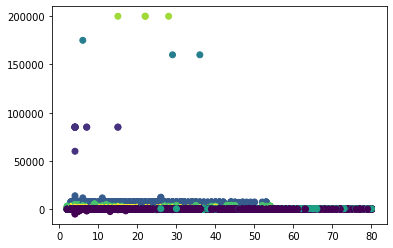

In [41]:
data = df[['ObjectNameLen', 'Object Duration']].dropna(axis = 0, how = 'any')
kmeans = KMeans(n_clusters=8, random_state=0).fit(data)
plt.scatter(x=data['ObjectNameLen'], y=data['Object Duration'], c=kmeans.labels_)
distances = kmeans.transform(data)
min_distances = pd.Series(np.apply_along_axis(min, 1, distances))
largestValues = df.loc[data.iloc[min_distances.nlargest(5).index].index]
largestValues[['Object ID', 'ObjectNameLen','Object Duration']]

## 6. Chybějící data

### Příznak 'Dimensions'
 * Nejprve se u příznaku podívejme, zda neobsahuje nějaké chybějící hodnoty zapsané pomocí řetězce.
 * Podezřelé jsou hodnoty délky kratší než 5. Z výpisu těchto hodnot vidíme prázdné hodnoty '\r\n' a '\r\n\r\n' a také nesmyslnou hodnotu obsahující pouze apostrof. Dále vidíme hodnotu 'N.A.', která také představuje chybějící hodnotu.
 * Dále si můžeme vypsat pro lepší analýzu hodnoty do délky 10. Zde si můžeme všimnout hodnoty 'Unknown', která nám naznačuje, že způsobů zápisů chybějících hodnot může být více. Sestavíme si pole nullValues skládájící se z hodnot, které obsahují řetězce 'not', 'Not', 'Un', 'available', 'recorded', '\r\n', 'N.A.' a zároveň nejsou moc dlouhé. Do tohoto pole také přidáme řetězce délky kratší než 2. Nemůžeme si být jistí, že jsme nalezli všechny hodnoty, které jsou ekvivalentní s chybějícími hodnotami, avšak všechny hodnoty, které jsou v poli, můžeme nahradit hodnotami NaN.
 * Poslední výstup říká, že původně bylo v datasetu 75475 NaN hodnot. Nově je v tabulce o 958 NaN hodnot více, tedy 76433.

In [42]:
df[df['Dimensions'].str.len()<5]['Dimensions'].unique()

array(['\r\n', 'Oban', '\r\n\r\n', '35mm', '33cm', '12vo', '`', '3 cm',
       'N.A.'], dtype=object)

In [43]:
df[df['Dimensions'].str.len()<10]['Dimensions'].unique()

array(['2 1/4 in.', '\r\n', 'Oban', '2 sizes', '55 x  in.', '\r\n\r\n',
       'D. 91 mm.', 'No meas.', '15 yards', '5 yards', '56.5 mm',
       '36.8 mm', '37.1 mm', 'Overall:', 'L. 1.8 cm', '18 mm.', '19 mm',
       'L. 2 cm', 'H. 14 cm.', 'H. 3 cm.', 'H. 14 cm', 'L. 2.5 cm',
       'L., 12"', 'H. 9 mm.', 'H. 9mm', 'L. 1.3 cm', 'L. 3.3 cm',
       'L. 1.5 cm', 'L. 1.1 cm', 'L. 2.1 cm', 'L. 3.7 cm', 'L. 1.9 cm',
       'L. 1.7 cm', 'L. 2.3 cm', 'Cut down', '3 x 4 in.', '4 x 5 in.',
       '5 x 7 in.', '4 x 6 in.', '6 x 8 in.', '35mm', '35mm each',
       '5 X 7 in.', '120mm', 'Variable', '3 x 2 3/4', '8 x 10', '11 x 14',
       '8 x 6', 'Various', '6 7/8 x 9', '8 x 6 1/8', '9 x 6 5/8',
       '9 5/8 x 5', 'Varies', '19.5 24.8', '33cm', 'H. 11 in.',
       'H. 34 in.', 'L. 7.7 cm', 'L. 54 cm', 'L. 32 cm', 'L. 28 cm',
       'H. 9.1 cm', 'H. 41 cm', 'H. 18 cm', '12vo', '8 1/4 x 6', '11x17',
       'various', '47 x 35.5', '`', '2 x 5 in', '3/4 in.', '3 1/4 in.',
       'H. 13 in.', '7 in

In [44]:
nullValues = []
for nullString in ["not", "Not", "Un", "available", "recorded" ]:
    newValues = df[df['Dimensions'].str.contains(nullString, regex=False)==True]['Dimensions'].unique()
    for value in list(filter(lambda x: len(str(x)) < 30, newValues)):
        nullValues.append(value)
for nullString in ["\r\n", "N.A."]:
    newValues = df[df['Dimensions'].str.contains(nullString, regex=False)==True]['Dimensions'].unique()
    for value in list(filter(lambda x: len(str(x)) < 5, newValues)):
        nullValues.append(value)
for value in list(df[df['Dimensions'].str.len()<2]['Dimensions'].unique()):
    nullValues.append(value)
print("Chybějící hodnoty v jiné podobě:\n")
print(nullValues)

Chybějící hodnoty v jiné podobě:

['Dimensions not available', 'Dimensions not recorded', 'Dimensions  not recorded', 'Cannot be measured\r\n', 'Can not be measured', 'not measured', 'Fragment not measured', 'not taken', 'cannot be measured', 'Cannot be measured', 'Not measured', 'Not measured.', 'Not available', 'Unknown', 'Dimensions unavailable', 'Dimensions not available', '[no dimensions available]', 'no dimensions available', 'Not available', 'Dimensions unrecorded', 'No dimensions recorded', 'Dimensions not recorded', 'Dimensions  not recorded', 'No dimensions recorded.', '\r\n', '\r\n\r\n', 'N.A.', '`']


In [45]:
oldCount = df['Dimensions'].isnull().sum()
print("Původní počet chybějících hodnot ve správném formátu: " + str(oldCount))
for nullValue in nullValues:
    df['Dimensions'].replace([nullValue], np.nan, inplace=True)
newCount = df['Dimensions'].isnull().sum()
print("Aktuální počet chybějících hodnot ve správném formátu: " + str(newCount))
print("Nově vytvořené chybějící hodnoty ve správném formátu: " + str(newCount - oldCount))

Původní počet chybějících hodnot ve správném formátu: 75475
Aktuální počet chybějících hodnot ve správném formátu: 76433
Nově vytvořené chybějící hodnoty ve správném formátu: 958


### Příznak Culture
 * Jako v předchozím případě, můžeme se podívat na výskyt "not", "Not", "Un", "available", "recorded", "\n", "N.A." v hodnotách příznaku 'Culture'. Zde si můžeme všimnout pouze hodnot "Unknown" a "N.A.".
 * Dále po vypsání hodnot, jejichž délka je kratší než 5 znaků si můžeme všimnout hodnoty "n.p." což nejspíše znamená "not provided". Další alternativy chybějících hodnot nalezeny nebyly.
 * Nahradíme tedy hodnoty "Unknown", "N.A." a "n.p." hodnotami NaN. Závěrečný výstup říká, že původně bylo v datasetu 268070 NaN hodnot. Nově je v tabulce o 142 NaN hodnot více, tedy 268212.

In [46]:
for value in ["not", "Not", "Un", "available", "recorded", "\n", "N.A." ]:
    print(list(df[df['Culture'].str.contains(value)==True]['Culture'].unique()))

[]
['British, Nottingham', 'British, probably Nottingham', 'British, Nottingham (Derbyshire)']
['American, New Berlin, Union County, Pennsylvania', 'India (Rajasthan, Uniara)', 'Unknown (China? Found in Vietnam)', 'Unknown', 'French (Unknown town) (Caen Mint)', 'Italian, working in France and United States', 'United States', 'United States (?)', 'Italian, Umbria and American (United States)', 'American, United States (New York?); and Italian or Spanish', 'American, United States (New York ?)', 'Italian (?) or American (United States?)', 'Italian or American (United States)', 'Italian, American (United States)', 'Italian (or United States?)', 'Italian or United States (?)', 'French (made United States)', 'Italian (?) or possibly United States (New York?)', 'American, United States', 'African; created in United Kingdom', 'Unknown fabric']
[]
[]
['South Indian\r\n', 'Cypriot\r\n', 'Tsimshian\r\n, Native American', 'Iran\r\n']
['N/A.']


In [47]:
df[df['Culture'].str.len()<5]['Culture'].unique()

array(['Bali', 'n.p.', 'Dyak', 'Thai', 'Nias', 'Laos', 'Maya', 'Inca',
       'Ica', 'Wari', 'Hopi', 'Cuna', 'Kuba', 'Zenú', 'Bozo', 'Bum',
       'Lobi', 'Guro', 'Bobo', 'Zuni', 'Viru', 'Nuna', 'Tiwi', 'Wapo',
       'Naga', 'Bete', 'Koko', 'Crow', 'Pomo', 'Awyu', 'Mau', 'Boa',
       'Mali', 'Nnam', 'Holo', 'Lio', 'Igbo', 'Peru', 'Nage', 'Lega',
       'Sao', 'Iran', 'Avar', 'Zulu', 'Hiwi', 'Ebo', 'Lozi', 'Fang',
       'Luba', 'Ketu', 'Dan', 'Edo', 'N/A.'], dtype=object)

In [48]:
npLines = df[df['Culture'].str.contains('n.p.', regex=False)==True]
npLines[['Culture', 'Period', 'Dynasty', 'Reign']]

,Culture,Period,Dynasty,Reign
21766,n.p.,NaN,NaN,NaN


In [49]:
oldCount = df['Culture'].isnull().sum()
print("Původní počet chybějících hodnot ve správném formátu: " + str(oldCount))
for nullValue in ["N.A.", "Unknown", 'n.p.']:
    df['Culture'].replace([nullValue], np.nan, inplace=True)
newCount = df['Culture'].isnull().sum()
print("Aktuální počet chybějících hodnot ve správném formátu: " + str(newCount))
print("Nově vytvořené chybějící hodnoty ve správném formátu: " + str(newCount - oldCount))

Původní počet chybějících hodnot ve správném formátu: 268070
Aktuální počet chybějících hodnot ve správném formátu: 268212
Nově vytvořené chybějící hodnoty ve správném formátu: 142


### Příznak 'AccessionYear'
 * Příznak 'Accession Year' již byl zpracován ve 4. části (konverze dat), tedy víme že chybějící hodnoty jsou zde reprezentovány správně pomocí hodnot NaN.
 * Hodnot NaN zde máme 3966 a tyto chybějící hodnoty se nyní pokusíme imputovat. 
 * Jelikož příznak 'Accession Year' je ve formátu datetime,vytvoříme si pomocné příznaky 'Year' a 'MedianYear', se kterými následně budeme pracovat. Následně si seskupíme data pomocí oddělení (příznak 'Department') a pro každé  oddělení spočteme medián, kterým poté nahradíme chybějící hodnotu NaN právě podle příslušného oddělení.
 * Zobrazená tabulka, ukazuje imputované hodnoty pomocného příznaku 'MedianYear', které jsou následně imputovány i do příznaku 'AccessionYear'.
 * Pomocné příznaky 'Year' a 'MedianYear' jsou po této proceduře smazány.
 

In [50]:
print("Původní počet chybějících hodnot: " + str(df['AccessionYear'].isnull().sum()))
df['Year'] = df['AccessionYear'].dt.year
df['MedianYear'] = df['AccessionYear'].dt.year
df.loc[df['Year'].isnull(), 'MedianYear'] = df[df['Year'].isnull()]['Department'].apply(lambda x: df.groupby('Department')['Year'].median()[x])
df.drop('Year', axis=1, inplace=True)
dataWithImpution = df[['Object ID', 'AccessionYear', 'MedianYear']]
dataWithImpution[dataWithImpution['AccessionYear'].isnull()]

Původní počet chybějících hodnot: 3966


,Object ID,AccessionYear,MedianYear
123,132,NaT,1951.0
130,141,NaT,1951.0
131,142,NaT,1951.0
238,279,NaT,1951.0
394,449,NaT,1951.0
...,...,...,...
474515,845712,NaT,2009.0
474516,845713,NaT,2009.0
474517,845714,NaT,2009.0
474523,846327,NaT,1920.0


In [51]:
df['AccessionYear'] = pd.to_datetime(df['MedianYear'], format='%Y').astype('datetime64[Y]')
df.drop('MedianYear', axis=1, inplace=True)
print("Nový počet chybějících hodnot: " + str(df['AccessionYear'].isnull().sum()))

Nový počet chybějících hodnot: 0
